# 检测 CUDA 版本


In [ ]:
!nvidia-smi

# 0. 相关库安装

### 1. 使用不低于 Python3.8 的 python 版本

### 2. 仅需要在新环境下运行此 cell

### 3. 若 CUDA 版本小于 12.1 请修改 torch 安装版本或使用 CPU 运算


In [ ]:
%pip install -r requirements.txt

In [ ]:
%pip freeze > requirements.txt

# 1. 准备工作

## 1.1 导入相关库


In [2]:
import os
import cv2
import csv
import copy
import time
import pickle
import json

import numpy as np
from numpy import ndarray
import pandas as pd
from PIL import Image, ImageFont, ImageDraw

from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
from dataclasses import dataclass

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import torch
from torchvision import transforms

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.rcParams['font.sans-serif']=['SimHei'] # 使用SimHei字体显示中文
plt.rcParams['axes.unicode_minus']=False   # 解决负号'-'显示为方块的问题

## 1.2 定义相关计算函数


In [3]:
def calculate_distance(point1,point2):
    """ 通过向量计算距离
    params:
    point1,point2 - 待计算的点，使用tuple或ndarray
    """
    if isinstance(point1, tuple):
        point1 = np.array(point1)
    if isinstance(point2, tuple):
        point2 = np.array(point2)
    return np.linalg.norm(point2 - point1)

def calculate_angle(point1, point2):
    """ 通过向量计算角度
    params:
    point1,point2 - 待计算的点，使用tuple或ndarray
    """
    if isinstance(point1, tuple):
        point1 = np.array(point1)
    if isinstance(point2, tuple):
        point2 = np.array(point2)
    dot_product = np.dot(point1, point2)
    length1 = np.linalg.norm(point1)
    length2 = np.linalg.norm(point2)
    cos_angle = dot_product / (length1 * length2)
    angle_radians = np.arccos(cos_angle)
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

## 1.3 设置主要参数


In [4]:
# 主要参数
USEGPU = True  # 使用GPU进行运算
# 读取与保存位置
PATH_LOCS = {
    "INPUT": Path("deeplab-resnet101-ade/input"),  # 输入数据集的位置（指没有经过处理的图片数据）
    "ADE_SPLIT": Path("deeplab-resnet101-ade/ade-split-output"),  # ADE语义分割后的结果保存位置
    "DIS_2D": Path("outputs/dis-2D-output"),  # 经过二维分析后的结果保存位置
    "DEPTH": Path("outputs/depth-output"),  # 经过MiDas单目深度估计后的结果保存位置
    "DIS_3D": Path("outputs/dis-3D-output"),  # 经过三维分析后的结果保存位置
    "TEMP_DATA": Path("outputs/temp-data"),
    "RESULT": Path("results")  # 保存分析结果的位置
}
# 创建没有的文件夹
for _, path in PATH_LOCS.items():
    path.mkdir(parents=True, exist_ok=True)

print("是否使用GPU运算：", "是" if USEGPU else "否")

是否使用GPU运算： 是


# 2. ADE 语义分割

（此处为 PyTorch 版本，仍未完成，请使用 mxnet-ade/mxnet_ade.ipynb 进行语义分割）


## 2.1 准备工作


### 2.1.1 读取类别映射


In [ ]:
type_f_path = Path("deeplab-resnet101-ade/type_f.json")

if type_f_path.exists():
    with open(type_f_path, 'r', encoding="utf8") as file:
        col_map = json.load(file)
        if col_map:
            print(f"读取 type_f.json 成功！获取了 {len(col_map)} 条映射数据.")
else:
    print(f"type_f.json 不存在！请检查文件结构.")

### 2.1.2 (废弃)定义运算的相关函数


In [ ]:
def overlay_mask_on_image(original_img_path, mask, output_folder, filename):
    original_img = Image.open(original_img_path)
    mask_img = mask.convert("RGBA")
    overlayed_img = Image.blend(original_img.convert("RGBA"), mask_img, 0.5)  # 调整遮罩透明度
    overlay_filename = filename.stem + '_overlay.png'
    overlay_path = output_folder / overlay_filename
    overlayed_img.save(overlay_path)
    return overlay_filename


def calculate_percentage(counts, total_pixels):
    return [count / total_pixels * 100 for count in counts]


def collect_segmentation_data(predict, col_map):
    unique_elements, counts_elements = np.unique(predict, return_counts=True)
    total_pixels = sum(counts_elements)
    counts_percentage = calculate_percentage(counts_elements, total_pixels)
    data = {col_map.get(k, 'Unknown'): v for k, v in zip(unique_elements, counts_percentage)}
    return data


def save_segmentation_stats_to_csv(data, output_folder, filename):
    df = pd.DataFrame([data])
    output_filename_csv = filename.stem + '_segmentation_stats.csv'
    save_path_csv = output_folder / output_filename_csv
    df.to_csv(save_path_csv, index=False)
    return output_filename_csv


def auto_adjust_chart_size(df):
    size = max(10, len(df.columns) / 2)
    return size


def save_visualization_chart(data, output_folder, filename):
    df = pd.DataFrame([data]).rename(columns=col_map)
    df = df.loc[:, df.sum() > 1]
    df['其他'] = 100 - df.sum(axis=1)
    chart_size = auto_adjust_chart_size(df)
    plt.figure(figsize=(chart_size, 6))
    df.T.plot(kind='bar', legend=False, width=0.8)
    plt.ylabel('Percentage (%)')
    plt.title(f'Segmentation Percentages for {filename.name}')
    plt.xticks(rotation=0)  # 确保x轴标签名称横向显示
    chart_filename = filename.stem + '_visualization_chart.png'
    save_path_chart = output_folder / chart_filename
    plt.savefig(save_path_chart)
    plt.cla()
    plt.close('all')


def compile_and_plot_segmentation_trends(segmentation_data, output_folder):
    df_compiled = pd.DataFrame(segmentation_data).T.rename(columns=col_map).fillna(0)
    mean_percentages = df_compiled.mean()
    significant_categories = mean_percentages[mean_percentages > 1].index
    df_compiled = df_compiled[significant_categories]
    plt.figure(figsize=(max(12, len(segmentation_data) * 0.5), 8))
    for column in df_compiled.columns:
        plt.plot(df_compiled.index, df_compiled[column], marker='o', label=column)
    plt.xlabel('图片索引')
    plt.ylabel('像素百分比')
    plt.title('Segmentation Trends Across Images')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    trends_filename = 'segmentation_trends.png'
    plt.savefig(output_folder / trends_filename)
    plt.cla()
    plt.close('all')


def segment_images(input_folder, output_folder, model, ctx) -> int:
    segmentation_data = {}
    for filename in tqdm(sorted(os.listdir(input_folder))):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            # 读取图片并归一化
            img_path = input_folder / Path(filename)
            img = image.imread(img_path)
            img = test_transform(img, ctx=ctx)
            # 进行预测
            output = model.predict(img)
            predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
            # 将所有判断为房屋的位置改为建筑，保持一致性
            predict[predict == 25] = 1
            # 创建遮罩
            mask = get_color_pallete(predict, 'ade')
            # 保存遮罩
            output_filename = filename.stem + '_seg_ade_101.png'
            save_path = output_folder / output_filename
            mask.save(save_path)
            # 透明化遮罩并覆盖到原图
            overlay_mask_on_image(img_path, mask, output_folder, img_path)
            # 统计图片内色块数据
            data = collect_segmentation_data(predict, col_map)
            save_segmentation_stats_to_csv(data, output_folder, img_path)
            save_visualization_chart(data, output_folder, img_path)
            segmentation_data[filename] = data
    # 保存像素百分比的条带
    compile_and_plot_segmentation_trends(segmentation_data, output_folder)
    return len(segmentation_data)

## 2.2 图片处理


### 2.2.1 载入模型


In [ ]:
ade_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
ade_model.eval()

### 2.2.2 使用 ADE 数据集对图片进行分割并处理相关数据


In [ ]:
# TODO
print("使用 PyTorch 进行图片语义分割.")
input_image = Image.open(PATH_LOCS['INPUT'] / "1.jpg")
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    ade_model.to('cuda')
with torch.no_grad():
    output = ade_model(input_batch)['out'][0]
output_predictions = output.argmax(0)
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)
plt.imshow(r)

# 3. 二维视角的图片处理与分析


## 3.1 准备工作


### 3.1.1 定义文件位置与颜色映射


In [5]:
# 处理后图片的文件位置
file_list = list(filter(lambda x: "seg_ade_101" in x, sorted(os.listdir(PATH_LOCS["ADE_SPLIT"]))))
# 颜色映射
color_mapping = {
    (0,0,128): "树",
    (0,128,0): "天空",
    (128,0,0): "建筑",
    (128,64,128): "水",
    (128,64,0): "植物",
    (0,128,64): "岩石",
    (192,64,0): "房子"
}
# 读取颜色映射中存在的颜色
valid_colors = list(color_mapping.keys())

### 3.1.2 定义相关类存储数据


In [6]:
@dataclass
class Collection:
    """ 存储质心和质心对应的框所在位置
    centroid(tuple) - 质心的位置（2D）
    stat(ndarray) - 质心对应所在位置([x,y,长,宽,面积])
    """
    centroid : tuple
    stat : ndarray

@dataclass
class SplitImg2D:
    """ 存储语义分割后的二维图片数据
    filename(str) - 文件名
    color_centers(dict[tuple, list[Collection]]) - 该图片中的各色快的信息
    """
    filename : str
    color_centers : 'dict[tuple, list[Collection]]'

    def get_ade_image(self):
        """获取ade处理后的图片"""
        image = cv2.imread(PATH_LOCS["ADE_SPLIT"] / self.filename)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    def get_origin_image(self):
        """获取源图片"""
        image =  cv2.imread(PATH_LOCS["INPUT"] / (self.filename.split("_")[0] + ".jpg"))
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## 3.2 图片处理

### 3.2.1 计算各色快的质心并将图片打包存储


In [ ]:
# 存储分割的图片对象
split_images_2d : 'list[SplitImg2D]' = []
for filename in tqdm(file_list):
    # 读取图片
    image = cv2.imread(PATH_LOCS["ADE_SPLIT"] / filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 找到图像中的所有唯一颜色
    unique_colors = np.unique(image.reshape(-1, image.shape[2]), axis=0)
    # 存储每一个色块的中心
    color_centers = defaultdict(list)
    # 遍历每个颜色，分割色块并计算其几何中心
    for color in unique_colors:
        if tuple(color) in valid_colors:
            # 创建一个遮罩，找到所有相同颜色的像素
            mask = cv2.inRange(image, color, color)
            # 通过连通性分离各色快
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
            # 去除第一个作为背景的色块
            centroids = centroids[1:]
            stats = stats[1:]
            #筛选合理的色块，去除太小的部分
            threshold_area = 900  # 设置阈值
            valid_labels = np.where(stats[:, cv2.CC_STAT_AREA] > threshold_area)[0]
            # 在color_centers字典中保存质点与质点对应的框
            for i in valid_labels:
                color_centers[tuple(color)].append(Collection(tuple(list(map(int,centroids[i]))), stats[i]))
    split_images_2d.append(SplitImg2D(filename, color_centers))
print("成功存储", len(split_images_2d), "份图片数据.")

### 3.2.2 （可选）存档图片数据

可以通过存档图片数据，后续无需再跑一次前面的步骤


In [ ]:
fname = str(time.time()) + ".pkl"
with open(PATH_LOCS["TEMP_DATA"] / fname, 'wb') as f:
    pickle.dump(split_images_2d, f)
print("图片信息已保存在", f"outputs/temp-data/{fname} 中.")

## 3.3 图片分析


### 3.3.1 （可选）读取图片数据

[重要]需要将 FNAME2D 改为图片数据的文件名


In [7]:
FNAME2D = "1721400572.4975064.pkl"

with open(PATH_LOCS['TEMP_DATA'] / FNAME2D, 'rb') as f:
    split_images_2d : 'list[SplitImg2D]' = pickle.load(f)
    if split_images_2d:
        print("已读取", len(split_images_2d), "条图片数据.")
    else:
        print("文件读取失败，请重试或重新生成文件.")

已读取 1242 条图片数据.


### 3.3.2 在原图中绘制质心


In [ ]:
for split_image in tqdm(split_images_2d):
    image = split_image.get_origin_image()
    for color, collections in split_image.color_centers.items():
        color = tuple(map(int, color))
        for collection in collections:
            center = collection.centorid
            stat = collection.stat
            # 绘制矩形
            cv2.rectangle(image, (stat[0],stat[1]), (stat[0]+stat[2],stat[1]+stat[3]), color=color)
            # 绘制点
            cv2.circle(image, center, 8, color=color, thickness=-1)
            # 标注字
            fontpath = "./simsun.ttc"
            font = ImageFont.truetype(fontpath, 16)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            draw.text((center[0] + 10, center[1] + 10),  f"{color_mapping[tuple(color)]}", font = font, fill = (255,255,255))
            image = np.array(img_pil)
    plt.imsave(PATH_LOCS["DIS_2D"] / (split_image.filename.split("_")[0] + "_2d_distance.png"), image)
print("质心图绘制成功，共", len(split_images_2d), "张，全部保存在outputs/dis-2D-output下.")

### 3.3.3 二维视角的距离和角度分析


In [ ]:
ignore_count = 0
for image_split in tqdm(split_images_2d):
    image = image_split.get_ade_image()
    x, y, _ = image.shape
    long = max(x,y)
    # 保存xy坐标和颜色值
    x = []
    y = []
    colors = []
    # 创建fig
    fig = plt.figure()
    ax = fig.subplots()
    # 设置坐标轴标签
    ax.set_xlabel('横向像素')
    ax.set_ylabel('纵向像素', rotation=90)
    # 读取图片信息
    for color, collections in image_split.color_centers.items():
        for collection in collections:
            center = collection.centorid
            x.append(center[0])
            y.append(long - center[1])
            colors.append(color)
    groups = {}
    datas = []
    # 色块分组
    for i, color in enumerate(colors):
        if color not in groups:
            groups[color] = []
        groups[color].append((x[i], y[i]))
    try:
        building_group = groups[(128,0,0)]
    except:
        print("图片", image_split.filename.split('_')[0], "没有建筑色块，已忽略.")
        ignore_count += 1
        continue
    #对色块的每一个点进行分析
    for color, points in groups.items():
        x, y = zip(*points)
        ax.scatter(x, y, c=[np.array(color)/255], label=color_mapping[color])
        if color_mapping[color] != "建筑":
            for i in range(len(x)):
                for j in range(len(building_group)):
                    ax.plot([x[i], building_group[j][0]], [y[i], building_group[j][1]], 'b--')
                    dis = calculate_distance((x[i],y[i]), building_group[j])
                    angle = calculate_angle(building_group[j], (x[i],y[i]))
                    data = {
                        "图片ID": image_split.filename.split("_")[0],
                        "要素类型":color_mapping[color],
                        "要素流向": f"{color_mapping[color]}-建筑",
                        "要素位置": f"({x[i]},{y[i]})",
                        "建筑位置": f"({building_group[j][0]}, {building_group[j][1]})",
                        "距离": dis,
                        "角度": angle
                        }
                    datas.append(data)
        else:
            for i in range(len(x)):
                for j in range(len(x)):
                    if i == j:
                        break
                    ax.plot([x[i], x[j]], [y[i], y[j]], 'r--')

    ax.legend(loc="upper right")
    # print(datas)
    # 保存数据和图片
    fig.savefig(PATH_LOCS["DIS_2D"] / ((str(image_split.filename.split('_')[0])) + "_2d_plot.png"))
    df = pd.DataFrame(datas)
    df.to_excel(PATH_LOCS["DIS_2D"] / ((str(image_split.filename.split('_')[0])) + "_2d_data.xlsx"))
    plt.cla()
    plt.close('all')
print("已成功处理", len(split_images_2d)-ignore_count, "张图片得到相关数据.")

### 3.3.4 汇总二维数据


In [ ]:
f_list = list(filter(lambda x: "2d_data" in x, sorted(os.listdir(PATH_LOCS["DIS_2D"]))))
DFs = [pd.read_excel(PATH_LOCS["DIS_2D"] / f, engine="openpyxl") for f in tqdm(f_list)]
concat_data = pd.concat(DFs)
concat_data.to_excel(PATH_LOCS["RESULT"] / "2d_results.xlsx", index=False)
print("已成功汇总二维数据，保存在",PATH_LOCS["RESULT"] / "2d_results.xlsx", "下.")

### 3.3.5 使用 DBSCAN 进行聚类分析


二维距离


In [ ]:
# 读取Excel文件
data = pd.read_excel(PATH_LOCS["RESULT"] / "2d_results.xlsx", engine="openpyxl")
# 提取不同的要素流向
flow_directions = data['要素流向'].unique()
# 准备存储聚类结果的列表
results = []
# 对每个要素点分别进行聚类
for direction in tqdm(flow_directions):
    # 提取当前要素流向的数据
    subset = data[data['要素流向'] == direction]
    directions = np.array(subset["距离"])
    directions = directions.reshape(-1, 1)
  
    db = DBSCAN(eps=1, min_samples=30).fit(directions)
    labels = db.labels_
    subset['聚类标签'] = labels
    # 计算密度
    unique_labels = set(labels)
    densities = np.zeros_like(labels, dtype=float)
    
    for k in unique_labels:
        if k != -1:
            # 计算每个聚类的密度
            class_member_mask = (labels == k)
            densities[class_member_mask] = np.sum(class_member_mask) / len(directions)
    
    # 绘制直线图
    plt.figure(figsize=(10, 2))
    
    # 创建颜色映射
    norm = Normalize(vmin=min(densities), vmax=max(densities))
    cmap = plt.get_cmap('Spectral')
    sm = ScalarMappable(norm=norm, cmap=cmap)
    
    # 为每个点绘制一条直线
    for i in range(len(directions)):
        plt.plot([directions[i], directions[i]], [0, densities[i]], color=sm.to_rgba(densities[i]), lw=2)
    
    plt.title(f'DBSCAN 聚类-{direction} | 距离 (eps=1, 最小样本数=30)')
    plt.xlabel('像素距离')
    plt.yticks([])  # 隐藏y轴刻度
    
    # 添加颜色条
    cbar = plt.colorbar(sm, orientation='vertical')
    cbar.set_label('密度')
    
    plt.savefig(PATH_LOCS["RESULT"]/ f'DBSCAN聚类-{direction}-距离.png')
    plt.show()

角度


In [ ]:
# 对每个要素点分别进行聚类
for direction in tqdm(flow_directions):
    # 提取当前要素流向的数据
    subset = data[data['要素流向'] == direction]
    directions = np.array(subset["角度"])
    directions = np.nan_to_num(directions, nan=0).reshape(-1, 1)
    
    db = DBSCAN(eps=0.1, min_samples=50).fit(directions)
    labels = db.labels_
    subset['聚类标签'] = labels
    # 计算密度
    unique_labels = set(labels)
    densities = np.zeros_like(labels, dtype=float)
    
    for k in unique_labels:
        if k != -1:
            # 计算每个聚类的密度
            class_member_mask = (labels == k)
            densities[class_member_mask] = np.sum(class_member_mask) / len(directions)
    
    # 绘制直线图
    plt.figure(figsize=(10, 2))
    
    # 创建颜色映射
    norm = Normalize(vmin=min(densities), vmax=max(densities))
    cmap = plt.get_cmap('Spectral')
    sm = ScalarMappable(norm=norm, cmap=cmap)
    
    # 为每个点绘制一条直线
    for i in range(len(directions)):
        plt.plot([directions[i], directions[i]], [0, densities[i]], color=sm.to_rgba(densities[i]), lw=2)
    
    plt.title(f'DBSCAN 聚类-{direction} | 角度 (eps=0.1, 最小样本数=50)')
    plt.xlabel('角度')
    plt.yticks([])  # 隐藏y轴刻度
    # 添加颜色条
    cbar = plt.colorbar(sm, orientation='vertical')
    cbar.set_label('密度')
    
    plt.savefig(PATH_LOCS["RESULT"]/ f'DBSCAN聚类-{direction}-角度.png')
    plt.show()

（废弃）二维点的聚类
这个聚类结果看不出关系


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

# 读取Excel文件
data = pd.read_excel(PATH_LOCS["RESULT"] / "2d_results.xlsx", engine="openpyxl")

# 提取不同的要素流向
flow_directions = data['要素流向'].unique()

# 准备存储聚类结果的列表
results = []

def batch_data(data, batch_size):
    for start in range(0, len(data), batch_size):
        yield data[start:start + batch_size]


# 对每个要素点分别进行聚类
for direction in tqdm(flow_directions):
    # 提取当前要素流向的数据
    subset = data[data['要素流向'] == direction]

    
    
    points = subset['要素位置'].values
    points = np.array(list(map(list, map(eval, points))))
    # 计算成对距离
    dist_matrix = pdist(points, metric='euclidean')

    # 将成对距离转换为方阵形式
    dist_matrix_square = squareform(dist_matrix)
    
    db = DBSCAN(eps=24, min_samples=4, metric='precomputed').fit(dist_matrix_square)
    labels = db.labels_
    subset['聚类标签'] = labels
    x = points.T[0]
    y = points.T[1]
    plt.scatter(x, y, c=subset['聚类标签'], cmap='viridis')
    plt.xlabel('横向像素')
    plt.ylabel('纵向像素')
    plt.title(f'DBSCAN聚类结果 - {direction}')
    plt.show()
    # plt.savefig(str(time.time()) + ".png")
    # 将当前要素流向的所有聚类结果保存到results列表
    results.append(subset)

# 4. 三维视角下的图片处理与距离分析


## 4.1 准备工作


### 4.1.1 读取二维数据结果


In [8]:
FILENAME2D = "1721400572.4975064.pkl"

with open(PATH_LOCS["TEMP_DATA"] / FILENAME2D, 'rb') as f:
    split_images_2d : 'list[SplitImg2D]' = pickle.load(f)
    if split_images_2d:
        print("已读取二维图片信息", len(split_images_2d), "份.")
    else:
        print("读取二维图片信息失败.")

已读取二维图片信息 1242 份.


## 4.2 图片处理


### 4.2.1 获取 MiDas 模型

@article{Ranftl2020,
author = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
title = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
journal = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
year = {2020},
}

@article{Ranftl2021,
author = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
title = {Vision Transformers for Dense Prediction},
journal = {ArXiv preprint},
year = {2021},
}


In [ ]:
# 下载并加载预训练的MiDaS模型
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

### 4.2.2 （可选）移动至 GPU 运算


In [ ]:
if USEGPU:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    device = torch.device("cpu")
midas.to(device)
midas.eval()

### 4.2.3 进行单目深度估计


In [ ]:
for filename in tqdm(os.listdir(PATH_LOCS['INPUT'])):
    
    img = cv2.imread(PATH_LOCS['INPUT'] / Path(filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    plt.imsave(PATH_LOCS['DEPTH'] / (filename.split(".")[0] + "_depth.png"), output, cmap='viridis')
    np.savetxt(PATH_LOCS['DEPTH'] / (filename.split(".")[0] + "_depth.csv"), output, delimiter=',')

## 4.3 图片分析


### 4.3.1 读取中心点对应的像素深度并制图，保存相关数据


In [ ]:
for image_info in tqdm(split_images_2d):
    depth_file = PATH_LOCS['DEPTH'] / (image_info.filename.split('_')[0] + "_depth.csv")
    image_split = cv2.imread(PATH_LOCS['ADE_SPLIT'] / image_info.filename)

    x = []
    y = []
    z = []
    colors = []

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # 设置坐标轴标签
    ax.set_xlabel('横向像素',rotation=-20)
    ax.set_ylabel('相对深度', rotation=50)
    ax.set_zlabel('纵向像素', rotation=90)

    with open(depth_file, 'r') as f:
        depth_list = list(csv.reader(f))
    for color, collections in image_info.color_centers.items():

        for collection in collections:
            center = collection.centorid
            # print(color, center)
            x.append(center[0])
            y.append(center[1])
            # 计算对应区域的平均深度
            image = copy.deepcopy(image_split)
            x1, y1 = collection.stat[0], collection.stat[1]
            x2, y2 = x1 + collection.stat[2], y1 + collection.stat[3]
            crop_image = image[y1: y2, x1 : x2]
            image_rgb = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)
            mask = cv2.inRange(image_rgb, np.array(color), np.array(color))
            positions = np.column_stack(np.where(mask > 0))
            positions[:, 0] += y1
            positions[:, 1] += x1
            #计算平均像素深度
            total_depth = 0
            for pos in positions:
                total_depth += float(depth_list[pos[0]][pos[1]])
            average_depth = total_depth / positions.size / 2
            z.append(average_depth)
            colors.append(color)

    groups = {}
    datas = []
    for i, color in enumerate(colors):
        if color not in groups:
            groups[color] = []
        groups[color].append((x[i], y[i], z[i]))
    try:
        building_group = groups[(128,0,0)]
    except:
        print("image", image_info.filename.split('_')[0], "has no building color blocks.")
        continue
    for color, points in groups.items():
        x, y, z = zip(*points)
        ax.scatter(y, z, x, c=[np.array(color)/255], label=color_mapping[color])
        if color_mapping[color] != "建筑":
            for i in range(len(x)):
                for j in range(len(building_group)):
                    ax.plot([y[i], building_group[j][1]], [z[i], building_group[j][2]], [x[i], building_group[j][0]], 'b--')
                    dis = calculate_distance((x[i],y[i],z[i]), building_group[j])
                    data = {
                        "要素类型":color_mapping[color],
                        "要素流向": f"{color_mapping[color]}-建筑",
                        "要素位置": f"{x[i]},{y[i]},{z[i]}",
                        "建筑位置": f"{building_group[j][0]}, {building_group[j][1]}, {building_group[j][2]}",
                        "距离": dis
                        }
                    datas.append(data)
        else:
            for i in range(len(x)):
                for j in range(len(x)):
                    if i == j:
                        break
                    ax.plot([y[i], y[j]], [z[i], z[j]], [x[i], x[j]], 'r--')
    ax.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    # print(datas)
    # 保存数据和图片
    fig.savefig(PATH_LOCS['DIS_3D'] / ((str(image_info.filename.split('_')[0])) + "_3d_plot.png"))
    df = pd.DataFrame(datas)
    df.to_excel(PATH_LOCS['DIS_3D'] / ((str(image_info.filename.split('_')[0])) + "_3d_data.xlsx"))
    plt.cla()
    plt.close('all')

### 4.3.2 汇总数据


In [9]:
f_list = list(filter(lambda x: "3d_data" in x, sorted(os.listdir(PATH_LOCS["DIS_3D"]))))
DFs = [pd.read_excel(PATH_LOCS["DIS_3D"] / f, engine="openpyxl") for f in tqdm(f_list)]
concat_data = pd.concat(DFs)
concat_data.to_excel(PATH_LOCS["RESULT"] / "3d_results.xlsx", index=False)
print("已成功汇总三维数据，保存在",PATH_LOCS["RESULT"] / "3d_results.xlsx", "下.")

100%|██████████| 1201/1201 [00:16<00:00, 72.16it/s]


已成功汇总三维数据，保存在 results\3d_results.xlsx 下.


### 4.3.3 使用 DBSCAN 进行聚类分析


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['聚类标签'] = labels
C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


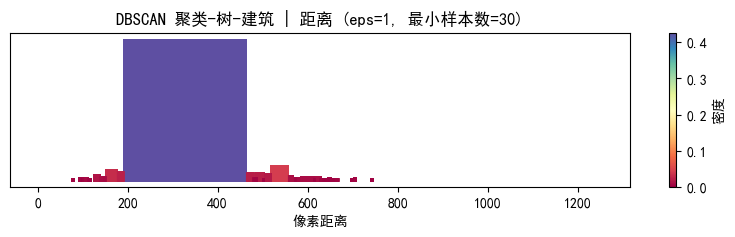

 20%|██        | 1/5 [00:11<00:44, 11.08s/it]C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['聚类标签'] = labels
C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


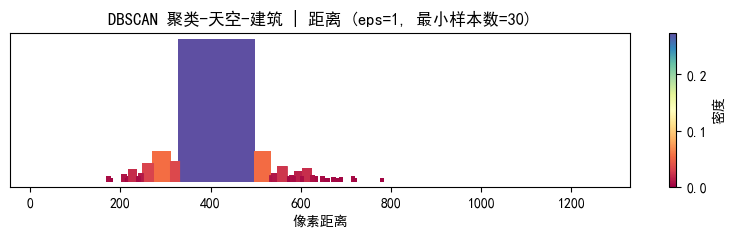

 40%|████      | 2/5 [00:22<00:33, 11.33s/it]C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['聚类标签'] = labels
C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


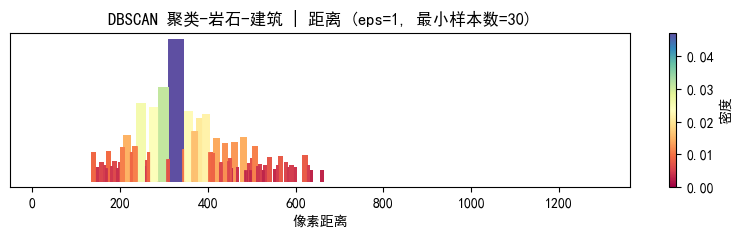

 60%|██████    | 3/5 [00:32<00:21, 10.74s/it]C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['聚类标签'] = labels
C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


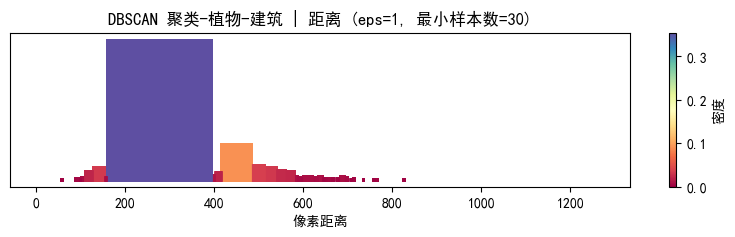

 80%|████████  | 4/5 [00:46<00:11, 11.99s/it]C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['聚类标签'] = labels
C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\1334459018.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


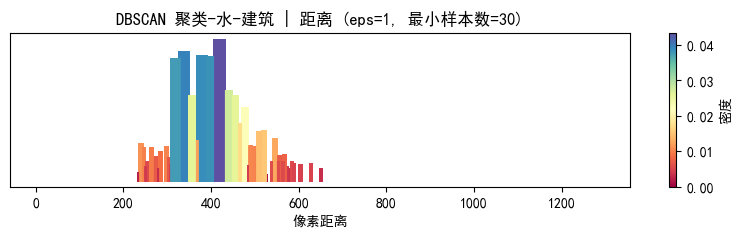

100%|██████████| 5/5 [00:54<00:00, 10.81s/it]


In [10]:
# 读取Excel文件
data = pd.read_excel(PATH_LOCS["RESULT"] / "3d_results.xlsx", engine="openpyxl")
# 提取不同的要素流向
flow_directions = data['要素流向'].unique()
# 准备存储聚类结果的列表
results = []
# 对每个要素点分别进行聚类
for direction in tqdm(flow_directions):
    # 提取当前要素流向的数据
    subset = data[data['要素流向'] == direction]
    directions = np.array(subset["距离"])
    directions = directions.reshape(-1, 1)
  
    db = DBSCAN(eps=1, min_samples=30).fit(directions)
    labels = db.labels_
    subset['聚类标签'] = labels
    # 计算密度
    unique_labels = set(labels)
    densities = np.zeros_like(labels, dtype=float)
    
    for k in unique_labels:
        if k != -1:
            # 计算每个聚类的密度
            class_member_mask = (labels == k)
            densities[class_member_mask] = np.sum(class_member_mask) / len(directions)
    
    # 绘制直线图
    plt.figure(figsize=(10, 2))
    
    # 创建颜色映射
    norm = Normalize(vmin=min(densities), vmax=max(densities))
    cmap = plt.get_cmap('Spectral')
    sm = ScalarMappable(norm=norm, cmap=cmap)
    
    # 为每个点绘制一条直线
    for i in range(len(directions)):
        plt.plot([directions[i], directions[i]], [0, densities[i]], color=sm.to_rgba(densities[i]), lw=2)
    
    plt.title(f'DBSCAN 聚类-{direction} | 距离 (eps=1, 最小样本数=30)')
    plt.xlabel('像素距离')
    plt.yticks([])  # 隐藏y轴刻度
    
    # 添加颜色条
    cbar = plt.colorbar(sm, orientation='vertical')
    cbar.set_label('密度')
    
    plt.savefig(PATH_LOCS["RESULT"]/ f'DBSCAN聚类-3D-{direction}-距离.png')
    plt.show()

### 4.3.4 (废弃)使用 DBSCAN 对点进行聚类


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Sparr\AppData\Local\Temp\ipykernel_15556\2193960472.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['聚类标签'] = labels
  0%|          | 0/5 [00:29<?, ?it/s]


TypeError: 'Text' object is not callable

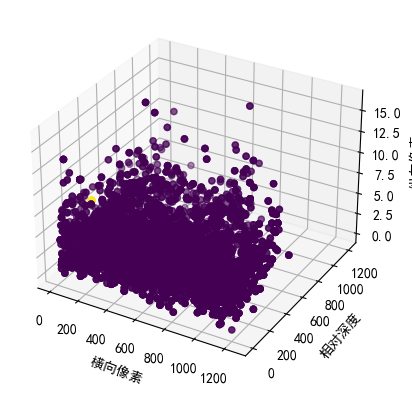

In [12]:
# 读取Excel文件
data = pd.read_excel(PATH_LOCS["RESULT"] / "3d_results.xlsx", engine="openpyxl")
# 提取不同的要素流向
flow_directions = data['要素流向'].unique()
# 准备存储聚类结果的列表
results = []
# 对每个要素点分别进行聚类
for direction in tqdm(flow_directions):
    # 提取当前要素流向的数据
    subset = data[data['要素流向'] == direction]
    points_data = subset['要素位置'].to_list()
    points = np.array([list(map(float, point.split(','))) for point in points_data])
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(points, points)
    
    db = DBSCAN(eps=1, min_samples=30).fit(dist_matrix)
    labels = db.labels_
    subset['聚类标签'] = labels
    x = points.T[0]
    y = points.T[1]
    z = points.T[2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # 设置坐标轴标签
    ax.set_xlabel('横向像素',rotation=-20)
    ax.set_ylabel('相对深度', rotation=50)
    ax.set_zlabel('纵向像素', rotation=90)
    ax.scatter(x, y, z, c=subset['聚类标签'], cmap='viridis')
    ax.title(f'DBSCAN聚类结果 - {direction}')
    fig.savefig(PATH_LOCS["RESULT"]/ f'DBSCAN聚类-3D-{direction}.png')
    ax.show()
    plt.cla()
    plt.close('all')